# Reinforcement Learning – Project 2 – Sam Linderoth


*Acknowledgement: I have used an LLM to generate code for the plots. The problem implementation and solutions have, however, been done by me personally.*

# Manual calulcations

## Problem 1.1 – Expected Sarsa

We follow Equation 6.9 on page 133 of Sutton & Barto, according to which

$$
Q(S_t, A_t) = Q(S_t, A_T) + \alpha \left[ R_{t+1} + \gamma \Sigma_{a} \pi(a \vert S_{t_+1}) Q(S_{t+1}, a) - Q(S_t, A_t) \right].
$$

Now, assuming $\alpha = 0.2, \gamma = 0.9$ and that all state-action values have value 1 before the update, we get

$$
\begin{align*}
Q(s_0, +) & = Q(s_0, +) + 0.2 \cdot \left[ 2 + 0.9 \cdot \Sigma_{a} \pi(a \vert S_{t+1}) Q(S_{t+1}, a) - Q(S_t, A_t) \right] \\
 & = 1 + 0.2 \cdot \left[ 2 + 0.9 \cdot \Sigma_{a} \pi(a \vert S_{t+1}) Q(S_{t+1}, a) - 1 \right] \\
 & = 1 + 0.2 \cdot \left[ 2 + 0.9 \cdot (0.5 Q(S_{t+1}, -) + 0.5 Q(S_{t+1}, +)) - 1 \right] \\
 & = 1 + 0.2 \cdot \left[ 2 + 0.9 \cdot 0.5 \cdot(1 +1) -1 \right] \\
 & = 1.38.\\
\end{align*}
$$

## Problem 1.2 – Importance sampling ratio

Following the definition of importance sampling ratio on page 104 of Sutton & Barto, we have

$$
\rho_{0:1} = \frac{\pi(+ \vert s_0)}{b(+ \vert s_0)} \cdot \frac{\pi(+ \vert s_1)}{b(+ \vert s_1)} = (\frac{0.5}{0.7})^2 \approx 0.51
$$

# Gridworld with a Monster

Now, we'll proceed to implement the given problem in code.

Beyond the instructions given, we'll set up the code so that if the agent lands on a tile where there's **both** an apple and a monster, the reward will be -1. Furthermore, we'll set epsilon for the greedy action selection at $\epsilon = 0.1$. We'll train the agent using 750 000 episodes for each of the different methods.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(900118)

def initialize_lists():

  '''
  A function to initialize dicts/lists used in the code.
  '''

  # Q dict
  Q = {((i, j), (k, l), (m, n)): {'left': 0, 'right': 0, 'up': 0, 'down': 0}
                          for i in range(5)
                          for j in range(5)
                          for k in range(5)
                          for l in range(5)
                          for m in range(5)
                          for n in range(5)}

  # Set grid
  grid = [(i, j) for i in range(5) for j in range(5)]

  # Reward storage
  episode_reward_storage = []

  return Q, grid, episode_reward_storage

def initialize_positions(grid):

  '''
  A function to initialize positions for the agent, monster and apple.
  '''

  grid_copy = grid.copy()

  agent_state = random.choice(grid_copy)
  grid_copy.remove(agent_state)
  monster_state = random.choice(grid_copy)
  grid_copy.remove(monster_state)
  apple_state = random.choice(grid_copy)

  return agent_state, monster_state, apple_state


def respawn_apple(grid, agent_state, monster_state):

  '''
  Apple respawn function.
  '''

  apple_state = random.choice(grid)
  while apple_state == agent_state or apple_state == monster_state:
    apple_state = random.choice(grid)

  return apple_state

def choose_action(Q, state, eps = 0.05):

  '''
  A function to choose actions.
  '''

  if random.random() < eps:
    return random.choice(list(Q[state].keys()))
  else:
    return max(Q[state], key=Q[state].get)

def take_action(action, state, grid):

  '''
  A function take a chosen action.
  '''

  # Store original state
  original_state = state

  # Take action
  if action == 'left':
    state = (state[0] - 1, state[1])
  elif action == 'right':
    state = (state[0] + 1, state[1])
  elif action == 'up':
    state = (state[0], state[1] + 1)
  elif action == 'down':
    state = (state[0], state[1] - 1)

  if state not in grid:
    return original_state
  else:
    return state

def get_return(agent_former_state, agent_current_state, apple_state, monster_state):

  '''
  A function to fetch returns/rewards.
  '''

  #if agent_current_state != apple_state and (np.abs(agent_current_state[0] - monster_state[0]) + np.abs(agent_current_state[1] - monster_state[1])) == 1:
   #   return -1/2
  if agent_current_state == apple_state and agent_current_state == monster_state:
    return -1 # Taking both apple and being caught, -1
  if agent_current_state == apple_state and agent_current_state != monster_state:
    return 1 # Taking apple
  if agent_current_state != apple_state and agent_current_state == monster_state:
    return -1 # Being caught by monster
  elif agent_former_state == agent_current_state:
    return 0 # Walking into a wall
  else:
    return 0 # Just walking

def sarsa_learn(Q, grid, episode_reward_storage, actions,
            alpha = 0.1, gamma = 0.9, eps = 0.05, T = 30):

  '''
  A function for 1-step Sarsa algorithm, following the pseudocode on page 130 of Sutton & Barto.

  Inputs
  ---------
  Q: State-action dict
  grid: The grid that the agent/monster/apple moves on
  episode_reward_storage: Reward storage
  actions: Action set (list)
  alpha: Learning rate (default: 0.1)
  gamma: Discount factor (default: 0.9)
  eps: Exploit/explore parameter (default: 0.05)
  T: Maximum steps (default: 30)

  Outputs
  ---------
  Q: Updated state-action dict
  episode_reward_storage: Updated reward storage
  '''

  # Initialize S
  agent_state, monster_state, apple_state = initialize_positions(grid)
  state = (agent_state, monster_state, apple_state)

  # Choose A from S using policy
  agent_action = choose_action(Q, state, eps = eps)

  reward_sum = 0
  t = 0
  while True:

    # Take action A, observe S', R
    agent_state = take_action(agent_action, agent_state, grid)
    monster_state = take_action(random.choice(actions), monster_state, grid)
    ret = get_return(state[0], agent_state, apple_state, monster_state) # R
    if agent_state == apple_state: # Update apple position if picked
      apple_state = respawn_apple(grid, agent_state, monster_state)
    new_state = (agent_state, monster_state, apple_state) # S'

    # Store reward
    reward_sum += ret

    # Choose A' from S'
    new_agent_action = choose_action(Q, new_state, eps = eps)

    if agent_state == monster_state or t == T:
      # Update Q, terminal state
      Q[state][agent_action] = Q[state][agent_action] + alpha * (ret - Q[state][agent_action])
      break
    else:
      # Update Q, nonterminal state
      Q[state][agent_action] = Q[state][agent_action] + alpha * (ret + gamma * Q[new_state][new_agent_action] - Q[state][agent_action])
      agent_action = new_agent_action # A <- A'
      state = new_state # S <- S'

    t += 1

  episode_reward_storage.append(reward_sum)

  return Q, episode_reward_storage


def n_step_sarsa(Q, n, grid, episode_reward_storage, actions,
                 alpha=0.1, gamma=0.9, eps=0.05, T=30):

    '''
    A function for n-step Sarsa algorithm, following the pseudocode on page 147 of Sutton & Barto.

    Inputs
    ---------
    Q: State-action dict
    n: Number of sarsa steps
    grid: The grid that the agent/monster/apple moves on
    episode_reward_storage: Reward storage
    actions: Action set (list)
    alpha: Learning rate (default: 0.1)
    gamma: Discount factor (default: 0.9)
    eps: Exploit/explore parameter (default: 0.05)
    T: Maximum steps (default: 30)

    Outputs
    ---------
    Q: Updated state-action dict
    episode_reward_storage: Updated reward storage
    '''

    # Initialize S
    agent_state, monster_state, apple_state = initialize_positions(grid)
    state = (agent_state, monster_state, apple_state)

    # Choose A from S using policy
    agent_action = choose_action(Q, state, eps=eps)

    # Store state and action
    local_states = [state]
    local_actions = [agent_action]
    local_rewards = []

    t = 0
    while True:
        if t < T:
            # Take action A, observe S', R
            agent_state = take_action(agent_action, agent_state, grid)
            monster_state = take_action(random.choice(actions), monster_state, grid)
            ret = get_return(local_states[-1][0], agent_state, apple_state, monster_state)
            if agent_state == apple_state:
                apple_state = respawn_apple(grid, agent_state, monster_state)
            new_state = (agent_state, monster_state, apple_state)

            # Store reward and next state
            local_rewards.append(ret)
            local_states.append(new_state)

            # If S' is terminal
            if agent_state == monster_state or t == T - 1:
                T = t + 1
            else:
                # Select and store and action A'
                agent_action = choose_action(Q, new_state, eps=eps)
                local_actions.append(agent_action)

        tau = t - n + 1 # tau is the time whose estimate is being updated
        if tau >= 0:
            G = sum([gamma**(i-tau) * local_rewards[i] for i in range(tau, min(tau+n, T))])
            if tau + n < T:
                G += gamma**n * Q[local_states[tau+n]][local_actions[tau+n]]
            Q[local_states[tau]][local_actions[tau]] += alpha * (G - Q[local_states[tau]][local_actions[tau]])

        # Until tau = T - 1
        if agent_state == monster_state or tau == T - 1:
            break

        # Update state
        state = new_state

        # Add time
        t += 1

    # Summarize episode rewards
    episode_reward_storage.append(sum(local_rewards))

    return Q, episode_reward_storage


def q_learn(Q, grid, episode_reward_storage, actions,
            alpha = 0.1, gamma = 0.9, eps = 0.05, T = 30):

  '''
  A function for Q-learning algorithm following the pseudocode on page 131 of Sutton & Barto.

  Inputs
  ---------
  Q: State-action dict
  grid: The grid that the agent/monster/apple moves on
  episode_reward_storage: Reward storage
  actions: Action set (list)
  alpha: Learning rate (default: 0.1)
  gamma: Discount factor (default: 0.9)
  eps: Exploit/explore parameter (default: 0.05)
  T: Maximum steps (default: 30)

  Outputs
  ---------
  Q: Updated state-action dict
  episode_reward_storage: Updated reward storage
  '''

  # Initialize S
  agent_state, monster_state, apple_state = initialize_positions(grid)
  state = (agent_state, monster_state, apple_state)

  t = 0
  reward_sum = 0
  while True:

    # Choose A from S
    # Take action A, observe R, S'
    agent_action = choose_action(Q, state, eps = eps)
    agent_state = take_action(agent_action, agent_state, grid)
    monster_state = take_action(random.choice(actions), monster_state, grid)
    ret = get_return(state[0], agent_state, apple_state, monster_state) # R
    if agent_state == apple_state: # Update apple position if picked
      apple_state = respawn_apple(grid, agent_state, monster_state)
    new_state = (agent_state, monster_state, apple_state) # S'

    # Store reward
    reward_sum += ret

    if agent_state == monster_state or t == T - 1:
      # Update Q, terminal state
      Q[state][agent_action] = Q[state][agent_action] + alpha * (ret - Q[state][agent_action])
      break
    else:
      # Update Q, nonterminal state
      Q[state][agent_action] = Q[state][agent_action] + alpha * (ret + gamma * max(Q[new_state].values()) - Q[state][agent_action])
      state = new_state # S <- S'

    t += 1

  episode_reward_storage.append(reward_sum)

  return Q, episode_reward_storage

def double_q_learn(Q1, Q2, grid, episode_reward_storage, actions,
                   alpha = 0.1, gamma = 0.9, eps = 0.05, T = 30):

    '''
    A function for the double Q-learning algorithm following the pseudocode on page 136 of Sutton & Barto.

    Inputs
    ---------
    Q1: State-action dict
    Q2: State-action dict
    grid: The grid that the agent/monster/apple moves on
    episode_reward_storage: Reward storage
    actions: Action set (list)
    alpha: Learning rate (default: 0.1)
    gamma: Discount factor (default: 0.9)
    eps: Exploit/explore parameter (default: 0.05)
    T: Maximum steps (default: 30)

    Outputs
    ---------
    Q: Updated state-action dict
    episode_reward_storage: Updated reward storage
    '''

    # Initialize S
    agent_state, monster_state, apple_state = initialize_positions(grid)
    state = (agent_state, monster_state, apple_state)

    t = 0
    reward_sum = 0
    while True:

        # Choose A from S using the e-greedy policy in Q_1 + Q_2
        if random.random() < eps:
            agent_action = random.choice(actions)
        else:
            q1_plus_q2 = {action: Q1[state][action] + Q2[state][action] for action in actions}
            agent_action = max(q1_plus_q2, key=q1_plus_q2.get)

        # Take action A, observe R, S'
        agent_state = take_action(agent_action, agent_state, grid)
        monster_state = take_action(random.choice(actions), monster_state, grid)
        ret = get_return(state[0], agent_state, apple_state, monster_state) # R
        if agent_state == apple_state: # Update apple position if picked
          apple_state = respawn_apple(grid, agent_state, monster_state)
        new_state = (agent_state, monster_state, apple_state) # S'

        # Store reward
        reward_sum += ret

        # With 0.5 probability, choose Q_1 or Q_2
        if random.random() < 0.5:
            update_Q, other_Q = Q1, Q2
        else:
            update_Q, other_Q = Q2, Q1

        if agent_state == monster_state or t == T:
            # Update Q, terminal state
            update_Q[state][agent_action] = update_Q[state][agent_action] + alpha * (ret - update_Q[state][agent_action])
            break
        else:
            # Update Q, nonterminal state
            optimal_action = max(update_Q[new_state], key=update_Q[new_state].get)
            update_Q[state][agent_action] = update_Q[state][agent_action] + alpha * (ret + gamma * other_Q[new_state][optimal_action] - update_Q[state][agent_action])
            state = new_state # S <- S'

        t += 1

    episode_reward_storage.append(reward_sum)

    return Q1, Q2, episode_reward_storage

actions = ['left', 'right', 'up', 'down']

In [3]:
random.seed(900118)

single_Q, grid, single_Q_episode_reward_storage = initialize_lists()
Q1, grid, double_Q_episode_reward_storage = initialize_lists()
Q2, _, _ = initialize_lists()
sarsa_Q, grid, sarsa_episode_reward_storage = initialize_lists()
step_2_sarsa_Q, grid, step_2_sarsa_episode_reward_storage = initialize_lists()
step_4_sarsa_Q, grid, step_4_sarsa_episode_reward_storage = initialize_lists()

n = 750_000

for i in range (n):
  eps = 0.1
  single_Q, single_Q_episode_reward_storage = q_learn(single_Q, grid, single_Q_episode_reward_storage, actions, eps = eps)
  Q1, Q2, double_Q_episode_reward_storage = double_q_learn(Q1, Q2, grid, double_Q_episode_reward_storage, actions, eps=eps)
  sarsa_Q, sarsa_episode_reward_storage = sarsa_learn(sarsa_Q, grid, sarsa_episode_reward_storage, actions, eps=eps)
  step_2_sarsa_Q, step_2_sarsa_episode_reward_storage = n_step_sarsa(step_2_sarsa_Q, 2, grid, step_2_sarsa_episode_reward_storage, actions, eps=eps)
  step_4_sarsa_Q, step_4_sarsa_episode_reward_storage = n_step_sarsa(step_4_sarsa_Q, 4, grid, step_4_sarsa_episode_reward_storage, actions, eps=eps)


Let's begin by looking at the episode rewards for each method, by plotting the 1000-episode average accumulated reward in Diagram 1.

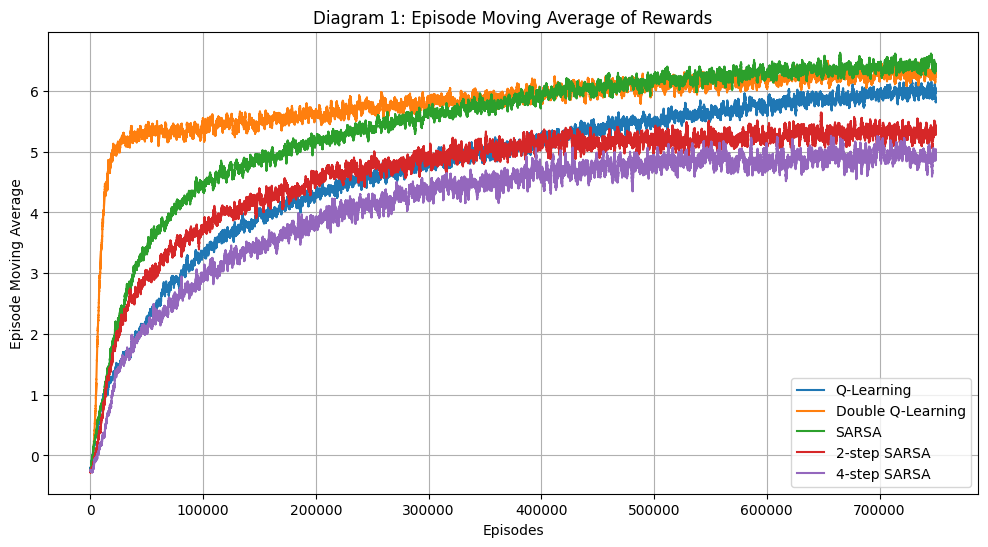

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Convert lists to NumPy arrays and calculate 100-window moving average
window_size = 1000
single_q = uniform_filter1d(np.array(single_Q_episode_reward_storage, dtype=float), size=window_size)
double_q = uniform_filter1d(np.array(double_Q_episode_reward_storage, dtype=float), size=window_size)
sarsa = uniform_filter1d(np.array(sarsa_episode_reward_storage, dtype=float), size=window_size)
step_2_sarsa = uniform_filter1d(np.array(step_2_sarsa_episode_reward_storage, dtype=float), size=window_size)
step_4_sarsa = uniform_filter1d(np.array(step_4_sarsa_episode_reward_storage, dtype=float), size=window_size)
#step_12_sarsa = uniform_filter1d(np.array(step_12_sarsa_episode_reward_storage, dtype=float), size=window_size)
#step_24_sarsa = uniform_filter1d(np.array(step_24_sarsa_episode_reward_storage, dtype=float), size=window_size)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(single_q, label='Q-Learning')
plt.plot(double_q, label='Double Q-Learning')
plt.plot(sarsa, label='SARSA')
plt.plot(step_2_sarsa, label='2-step SARSA')
plt.plot(step_4_sarsa, label='4-step SARSA')
#plt.plot(step_12_sarsa, label='12-step SARSA')
#plt.plot(step_24_sarsa, label='24-step SARSA')
plt.title('Diagram 1: Episode Moving Average of Rewards')
plt.xlabel('Episodes')
plt.ylabel('Episode Moving Average')
plt.legend()
plt.grid(True)
plt.show()

We begin by noting that Double Q-learning performs very differently as compared to the other methods, in that it much more quickly learns a more valuable policy with higher rewards in each episode.

This is due to the maximization bias in Single Q-learning, which makes the agent get stuck in less optimal behaviors. In fact, Single Q-learning performs pretty bad in terms of convergence and still lags the Double Q-approach after 750 000 episodes.

As for the Sarsa methods, there are some differences in convergence between the different settings. The 4 and 2-step Sarsa converges faster than "standard" 1-step Sarsa, but converges to a less profitable policy than the latter.

To summarize the answers for each question given in the exercise sheet:

**Which method converges the fastest?**

The Double Q-learning approach is the fastest convering method.

**Is there an optimal n for n-step SARSA? Note that n = 1 is equivalent to SARSA.**

That depends on what we mean by "optimal". In terms of convergence, 4- and 2-step Sarsa is faster than the standard 1-step approach. However, in terms of a more valuable policy, the 1-step Sarsa is the best.

**Do the n-step SARSA methods converge at different rates? If yes, why. If no, why not?**

Yes. The 4 and 2-step Sarsas converges the fastest, but learns a less valuable policy.

This is due to 4- and 2-step Sarsa taking into account future returns in a different manner than 1-step Sarsa. By the looks of it, the longer-window methods learn a more careful policy - likely to avoid the monster at the cost of getting more apples. The standard Sarsa seems to learn a more greedy policy, but takes longer to adapt to it in an optimal manner.

**Does double Q-learning differ from Q-learning in this case? Why or why not?**

Yes, there is a significant difference in terms of how fast the methods converge to the optimal policy.

The reason is that Double Q-learning does not suffer from the maximization bias that Single Q-learning does, and thereby does not get stuck a suboptimal policy.

**If the monster moves toward the player deterministically instead, how would this affect the convergence of the methods?**

In all likelihood, the methods would have converged faster due to the predictability of the monster. As for the current setup, the agent is not always necessarily taught that it is dangerous to stand close to the monster, since the monster may actually move away from the agent due to the randomness.

Had the monster instead followed the agent deterministically, the agent would have learned more quickly to stay away from it.